In [1]:
import pandas as pd
import numpy as np


In [2]:
train_data_initial = pd.read_csv("train.csv")
train_data = train_data_initial.copy()
train_data_initial.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train_data.loc[train_data['Transported'] == True, 'Transported'] = 1
train_data.loc[train_data['Transported'] == False, 'Transported'] = 0

train_data.loc[train_data['CryoSleep'] == True, 'CryoSleep'] = 1
train_data.loc[train_data['CryoSleep'] == False, 'CryoSleep'] = 0

train_data['Costs'] = train_data['RoomService'] + train_data['FoodCourt'] + train_data['ShoppingMall'] + train_data['Spa'] + train_data['VRDeck']
train_data.drop(columns=['Name', 'PassengerId', 'HomePlanet','Destination','VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], inplace = True)

train_data.head(15)

,CryoSleep,Cabin,Age,Transported,Costs
0,0,B/0/P,39.0,0,0.0
1,0,F/0/S,24.0,1,736.0
2,0,A/0/S,58.0,0,10383.0
3,0,A/0/S,33.0,0,5176.0
4,0,F/1/S,16.0,1,1091.0
5,0,F/0/P,44.0,1,774.0
6,0,F/2/S,26.0,1,1584.0
7,1,G/0/S,28.0,1,NaN
8,0,F/3/S,35.0,1,1018.0
9,1,B/1/P,14.0,1,0.0


In [4]:
train_data['Cabin'].replace('', np.nan, inplace=True)
train_data.dropna(subset=['Cabin'], inplace=True)
train_data['Costs'] = train_data['Costs']. fillna(train_data['Costs'].mean())
train_data['Age'] = train_data['Age']. fillna(train_data['Age'].mean())
train_data['CryoSleep'] = train_data['CryoSleep']. fillna(False)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8494 entries, 0 to 8692
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CryoSleep    8494 non-null   object 
 1   Cabin        8494 non-null   object 
 2   Age          8494 non-null   float64
 3   Transported  8494 non-null   object 
 4   Costs        8494 non-null   float64
dtypes: float64(2), object(3)
memory usage: 398.2+ KB


In [5]:
means = list(range(1, 6561))
train_data['Cabin'] = train_data['Cabin'].replace(train_data['Cabin'].unique(), means)
#train_data['PassengerId'] = train_data['PassengerId'].astype(float)
#train_data['HomePlanet'] = train_data['HomePlanet'].replace(train_data['HomePlanet'].unique(), [1,2,3])
train_data.head(15)

,CryoSleep,Cabin,Age,Transported,Costs
0,0,1,39.0,0,0.000000
1,0,2,24.0,1,736.000000
2,0,3,58.0,0,10383.000000
3,0,3,33.0,0,5176.000000
4,0,4,16.0,1,1091.000000
5,0,5,44.0,1,774.000000
6,0,6,26.0,1,1584.000000
7,1,7,28.0,1,1480.246876
8,0,8,35.0,1,1018.000000
9,1,9,14.0,1,0.000000


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import catboost as cb

In [7]:
X = train_data.drop(columns='Transported')
y = train_data['Transported']

# Разделим данные на обучене и тест (как и раньше со стратификацией по таргету)
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.4, train_size=0.6, random_state=14, stratify=y, shuffle=True)
print("train", len(X_train), len(y_train))
print("test", len(X_test1), len(y_test1))
X_valid, X_test, y_valid, y_test = train_test_split(X_test1, y_test1, test_size=0.5, train_size=0.5, random_state=14, stratify=y_test1, shuffle=True)

model = cb.CatBoostClassifier(verbose=0)
model.fit(X_train, y_train)

y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)

train 5096 5096
test 3398 3398


0.7690134212385213
TEST
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      2108
           1       0.82      0.69      0.75      2139

    accuracy                           0.77      4247
   macro avg       0.78      0.77      0.77      4247
weighted avg       0.78      0.77      0.77      4247

TRAIN
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      2529
           1       0.82      0.68      0.74      2567

    accuracy                           0.76      5096
   macro avg       0.77      0.77      0.76      5096
weighted avg       0.77      0.76      0.76      5096



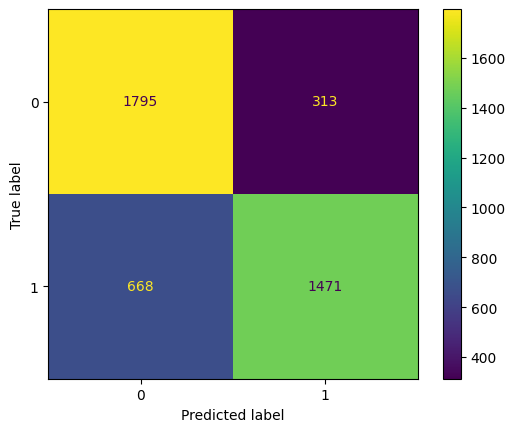

In [13]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, hamming_loss

print(accuracy_score(list(y_valid), y_pred_valid, normalize=True, sample_weight=None))
print("TEST")
print(classification_report(list(y_valid), model.predict(X_valid)))
print("TRAIN")
print(classification_report(list(y_train), model.predict(X_train)))

# # Посмотреть на матрицу ошибок, передав в plot_confusion_matrix модель, тестовые данные и тестовые метки
confusion_matrix = confusion_matrix(list(y_valid), model.predict(X_valid))
ConfusionMatrixDisplay(confusion_matrix, display_labels=[0, 1]).plot()

plt.show()